In [1]:
!pip install transformers torch scikit-learn pandas numpy matplotlib einops

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import math
from einops import rearrange
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

file_path = 'urdu_sarcasm_cleaned.csv'

if not os.path.exists(file_path):
    print(f"Error: File '{file_path}' not found!")
    raise FileNotFoundError(f"File '{file_path}' not found")

df = pd.read_csv(file_path)
print(f"Dataset loaded. Shape: {df.shape}")

texts = df['clean_text'].astype(str).tolist()
labels = df['is_sarcastic'].astype(int).tolist()

print(f"Total samples: {len(texts)}")
print(f"Sarcastic (1): {sum(labels)}")
print(f"Non-sarcastic (0): {len(labels) - sum(labels)}")

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Dataset loaded. Shape: (19955, 2)
Total samples: 19955
Sarcastic (1): 9962
Non-sarcastic (0): 9993

Training samples: 15964
Testing samples: 3991


In [4]:
def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin):
    cos = cos.unsqueeze(0).unsqueeze(1)
    sin = sin.unsqueeze(0).unsqueeze(1)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=512):
        super().__init__()
        self.dim = dim
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.max_seq_len = max_seq_len
        self.build_cache(max_seq_len)

    def build_cache(self, seq_len):
        t = torch.arange(seq_len, device=self.inv_freq.device).type_as(self.inv_freq)
        freqs = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos())
        self.register_buffer("sin_cached", emb.sin())

    def forward(self, seq_len):
        if seq_len > self.max_seq_len:
            self.build_cache(seq_len)
            self.max_seq_len = seq_len
        return self.cos_cached[:seq_len], self.sin_cached[:seq_len]

In [5]:
class ConformerBlock(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, ff_mult=4, conv_expansion_factor=2):
        super().__init__()
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5
        self.inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, self.inner_dim * 3, bias=False)
        self.to_out = nn.Linear(self.inner_dim, dim)

        ff_inner_dim = dim * ff_mult
        self.ff = nn.Sequential(
            nn.Linear(dim, ff_inner_dim),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(ff_inner_dim, dim)
        )

        conv_inner_dim = dim * conv_expansion_factor
        self.conv = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, conv_inner_dim),
            nn.GLU(dim=-1),
            nn.Conv1d(
                conv_inner_dim//2,
                conv_inner_dim//2,
                kernel_size=31,
                padding=15,
                groups=conv_inner_dim//2
            ),
            nn.SiLU(),
            nn.Linear(conv_inner_dim//2, dim)
        )

        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(0.1)
        self.rope = RotaryPositionalEmbedding(dim_head)

    def forward(self, x, mask=None):
        batch, seq_len, _ = x.shape

        residual = x
        x = self.norm1(x)
        x = self.ff(x) * 0.5
        x = residual + self.dropout(x)

        residual = x
        x = self.norm2(x)

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        cos, sin = self.rope(seq_len)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            dots = dots.masked_fill(mask == 0, -1e9)

        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        x = residual + self.dropout(out)

        residual = x
        x = self.norm3(x)

        conv_out = self.conv[0](x)
        conv_out = self.conv[1](conv_out)
        conv_out = self.conv[2](conv_out)
        conv_out = conv_out.permute(0, 2, 1)
        conv_out = self.conv[3](conv_out)
        conv_out = conv_out.permute(0, 2, 1)
        conv_out = self.conv[4](conv_out)
        conv_out = self.conv[5](conv_out)
        x = residual + self.dropout(conv_out)

        residual = x
        x = self.norm1(x)
        x = self.ff(x) * 0.5
        x = residual + self.dropout(x)

        return x

In [6]:
class XLMR_Conformer_Sarcasm(nn.Module):
    def __init__(self, n_classes=2, conformer_layers=4, dim_head=64, heads=8):
        super().__init__()
        self.xlmr = AutoModel.from_pretrained('xlm-roberta-base')
        xlmr_dim = 768

        self.char_cnn = nn.Sequential(
            nn.Conv1d(xlmr_dim, 256, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.AdaptiveMaxPool1d(1)
        )

        self.projection = nn.Linear(xlmr_dim, 512)

        self.conformer_layers = nn.ModuleList([
            ConformerBlock(
                dim=512,
                dim_head=dim_head,
                heads=heads,
                ff_mult=4,
                conv_expansion_factor=2
            )
            for _ in range(conformer_layers)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(512 + 128),
            nn.Linear(512 + 128, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes)
        )

        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        xlmr_outputs = self.xlmr(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        xlmr_features = xlmr_outputs.last_hidden_state
        xlmr_features = self.dropout(xlmr_features)

        char_features = self.char_cnn(xlmr_features.permute(0, 2, 1))
        char_features = char_features.squeeze(-1)

        projected = self.projection(xlmr_features)

        conformer_out = projected
        for layer in self.conformer_layers:
            conformer_out = layer(conformer_out, attention_mask)

        pooled = conformer_out.mean(dim=1)

        combined = torch.cat([pooled, char_features], dim=1)
        combined = self.dropout(combined)

        logits = self.classifier(combined)

        return logits

In [7]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

model = XLMR_Conformer_Sarcasm(
    n_classes=2,
    conformer_layers=4,
    dim_head=64,
    heads=8
)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [8]:
class UrduSarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = UrduSarcasmDataset(X_train, y_train, tokenizer)
test_dataset = UrduSarcasmDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [9]:
def train_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []

    for batch_idx, batch in enumerate(data_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = F.cross_entropy(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if scheduler:
            scheduler.step()

        total_loss += loss.item()

        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        if (batch_idx + 1) % 10 == 0:
            print(f'Batch {batch_idx + 1}/{len(data_loader)}, Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_predictions)

    return avg_loss, accuracy

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = F.cross_entropy(outputs, labels)

            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, output_dict=True)

    return avg_loss, accuracy, report

In [10]:
EPOCHS = 10
LEARNING_RATE = 2e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')

    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, device, scheduler
    )

    val_loss, val_acc, val_report = eval_model(model, test_loader, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if epoch == 0 or val_acc > max(val_accuracies[:-1]):
        torch.save(model.state_dict(), 'best_conformer_model.pth')

Epoch 1/10
Batch 10/1996, Loss: 0.7406
Batch 20/1996, Loss: 0.7375
Batch 30/1996, Loss: 0.6869
Batch 40/1996, Loss: 0.6848
Batch 50/1996, Loss: 0.5711
Batch 60/1996, Loss: 0.6893
Batch 70/1996, Loss: 0.5709
Batch 80/1996, Loss: 0.4992
Batch 90/1996, Loss: 0.5813
Batch 100/1996, Loss: 0.6644
Batch 110/1996, Loss: 0.5637
Batch 120/1996, Loss: 0.5877
Batch 130/1996, Loss: 0.5678
Batch 140/1996, Loss: 0.4126
Batch 150/1996, Loss: 0.5310
Batch 160/1996, Loss: 0.4487
Batch 170/1996, Loss: 0.4507
Batch 180/1996, Loss: 0.5982
Batch 190/1996, Loss: 0.4812
Batch 200/1996, Loss: 0.8246
Batch 210/1996, Loss: 0.6324
Batch 220/1996, Loss: 0.5677
Batch 230/1996, Loss: 0.6473
Batch 240/1996, Loss: 0.7023
Batch 250/1996, Loss: 0.5307
Batch 260/1996, Loss: 0.4280
Batch 270/1996, Loss: 0.4954
Batch 280/1996, Loss: 0.5108
Batch 290/1996, Loss: 0.4567
Batch 300/1996, Loss: 0.5110
Batch 310/1996, Loss: 0.9027
Batch 320/1996, Loss: 0.7376
Batch 330/1996, Loss: 0.7171
Batch 340/1996, Loss: 0.3908
Batch 350/19

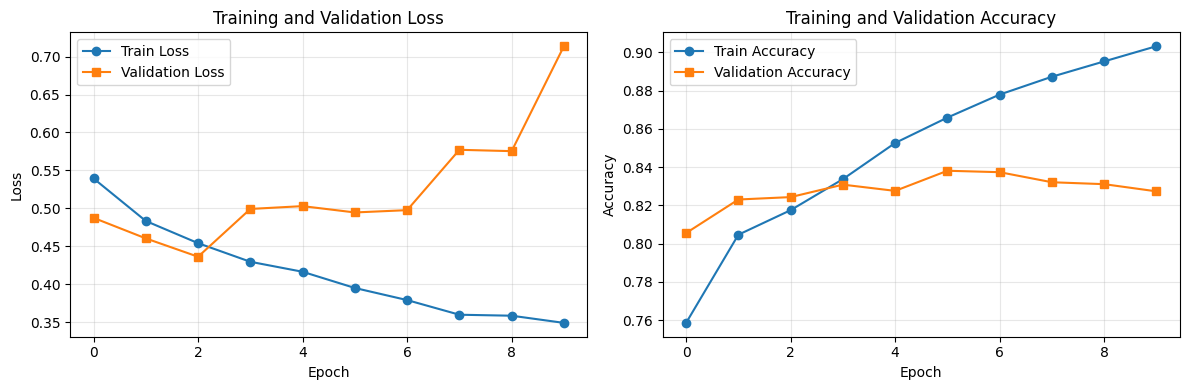

Test Accuracy: 0.8274
Test F1-Score: 0.8327
Test Precision: 0.8063
Test Recall: 0.8609


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accuracies, label='Train Accuracy', marker='o')
axes[1].plot(val_accuracies, label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

_, final_acc, final_report = eval_model(model, test_loader, device)
print(f"Test Accuracy: {final_acc:.4f}")
print(f"Test F1-Score: {final_report['1']['f1-score']:.4f}")
print(f"Test Precision: {final_report['1']['precision']:.4f}")
print(f"Test Recall: {final_report['1']['recall']:.4f}")

In [12]:
# Save the complete model (architecture + weights)
torch.save({
    'model_state_dict': model.state_dict(),
    'tokenizer': tokenizer,
    'config': {
        'n_classes': 2,
        'conformer_layers': 4,
        'dim_head': 64,
        'heads': 8
    }
}, 'urdu_sarcasm_model_complete.pth')

print("Complete model saved as 'urdu_sarcasm_model_complete.pth'")

Complete model saved as 'urdu_sarcasm_model_complete.pth'


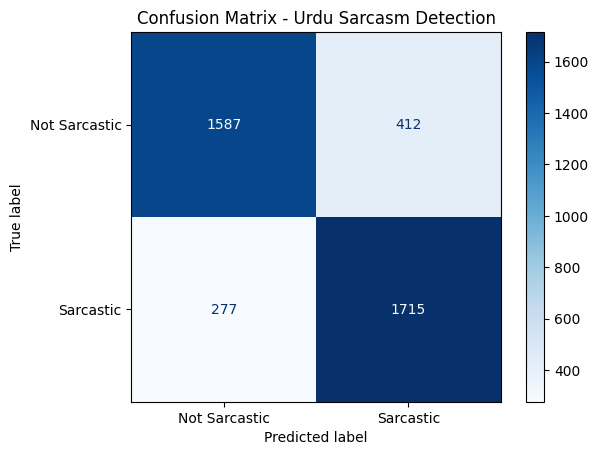

Confusion Matrix:
True Negatives (Not Sarcastic → Not Sarcastic): 1587
False Positives (Not Sarcastic → Sarcastic): 412
False Negatives (Sarcastic → Not Sarcastic): 277
True Positives (Sarcastic → Sarcastic): 1715


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_predictions

labels, predictions = get_predictions(model, test_loader, device)

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sarcastic', 'Sarcastic'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Urdu Sarcasm Detection')
plt.show()

print("Confusion Matrix:")
print(f"True Negatives (Not Sarcastic → Not Sarcastic): {cm[0][0]}")
print(f"False Positives (Not Sarcastic → Sarcastic): {cm[0][1]}")
print(f"False Negatives (Sarcastic → Not Sarcastic): {cm[1][0]}")
print(f"True Positives (Sarcastic → Sarcastic): {cm[1][1]}")